In [1]:
# /Users/teliov/TUD/Thesis/Medvice/Notebooks/data/04_06_new_data/data/split
# So we can use the *thesislib* package
import sys
import os

module_path = os.path.abspath("..")

if module_path not in sys.path:
    sys.path.append(module_path)

This notebook evaluates results of the grid search for optimal Random Forest parameters when trained on the basic_5k (no modifications) data set.

In [2]:
from thesislib.utils import pathutils

In [3]:
from glob import glob

In [4]:
results_path = pathutils.get_data_file("zz_qce_data/random_forest_grid_search/grid_search")

In [6]:
grid_search_files = glob(results_path + "/*.json")

In [8]:
# features that we were searching on
features = ["n_estimators", "criterion", "max_depth", "min_samples_split", "min_samples_leaf", "max_leaf_nodes", "max_features"]

In [68]:
import re
import json

In [156]:
grid_params = []
names = []
train_accuracy = []
test_accuracy = []
top_2_train = []
top_2_test = []
top_5_train = []
top_5_test = []
train_time = []
test_time = []
score_time = []
model_size = []
index = []
for idx, file in enumerate(grid_search_files):
    with open(file) as fp:
        results = json.load(fp)
    
    name = results.get("name")
    grid_params_str = name.split(" ")[-1]
    
    params = {}
    for feature in features:
        regex = "%s_([0-9A-Za-z]+)" % feature
        m = re.search(regex, sample_str)
        if  m is None:
            params[feature] = None
            continue
        value = m.group(0).split("_")[-1]
        if value == "None":
            value = None
        params[feature] = value
    
    names.append(name)
    grid_params.append(params)
    train_accuracy.append(results.get("accuracy").get("train"))
    test_accuracy.append(results.get("accuracy").get("test"))
    top_2_train.append(results.get("top_2").get("train"))
    top_2_test.append(results.get("top_2").get("test"))
    top_5_train.append(results.get("top_5").get("train"))
    top_5_test.append(results.get("top_5").get("test"))
    train_time.append(results.get("stats").get("train_time"))
    score_time.append(results.get("stats").get("score_time"))
    model_size.append(results.get("stats").get("model_size"))
    index.append(idx)

In [157]:
import pandas as pd

In [158]:
import numpy as np

In [159]:
grid = {
    "names": names, "train_accuracy": train_accuracy, "test_accuracy": test_accuracy,
    "top_2_train": top_2_train, "top_2_test": top_2_test, "top_5_train": top_5_train, "top_5_test": top_5_test,
    "train_time": train_time, "score_time": score_time, "model_size": model_size
}

In [160]:
index = np.array(index)

In [161]:
index.shape

(232,)

In [162]:
df = pd.DataFrame(grid, index=index)
df["model_size_MB"] = df.model_size.apply(lambda v: v/1024/1024)

In [163]:
highest_train_idx = df.train_accuracy.idxmax()
highest_train_accuracy = df.train_accuracy[highest_train_idx]
highest_train_accuracy_test_acc = df.test_accuracy
df.loc[highest_train_idx]

names             RF n_estimators_30_criterion_gini_max_depth_38...
train_accuracy                                             0.638515
test_accuracy                                              0.595986
top_2_train                                                0.756662
top_2_test                                                 0.716537
top_5_train                                                0.879545
top_5_test                                                 0.852087
train_time                                                  2693.09
score_time                                                  2091.66
model_size                                              35655779042
model_size_MB                                                 34004
Name: 70, dtype: object

In [164]:
highest_test_idx = df.test_accuracy.idxmax()
df.loc[highest_test_idx]

names             RF n_estimators_30_criterion_gini_max_depth_20...
train_accuracy                                             0.636273
test_accuracy                                              0.596306
top_2_train                                                0.754076
top_2_test                                                 0.716039
top_5_train                                                0.877123
top_5_test                                                 0.851289
train_time                                                  2602.25
score_time                                                  2192.46
model_size                                              35265650727
model_size_MB                                               33631.9
Name: 149, dtype: object

In [165]:
lowest_model_size_idx = df.model_size.idxmin()
df.loc[lowest_model_size_idx]

names             RF n_estimators_10_criterion_gini_max_depth_38...
train_accuracy                                             0.547683
test_accuracy                                              0.540025
top_2_train                                                0.674852
top_2_test                                                 0.666365
top_5_train                                                 0.82775
top_5_test                                                 0.818769
train_time                                                  320.496
score_time                                                  1029.21
model_size                                               1425206837
model_size_MB                                               1359.18
Name: 61, dtype: object

In [166]:
import matplotlib.pyplot as plt

In [167]:
# plot train_size against model_size
# plot test_size agains model_size

train_acc = df.train_accuracy
test_acc = df.test_accuracy
model_sizes = df.model_size

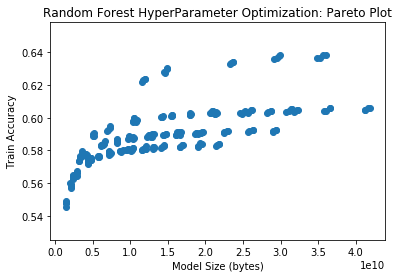

In [286]:
fig, axes = plt.subplots()

axes.set_title("Random Forest HyperParameter Optimization: Pareto Plot")
axes.set_xlabel("Model Size (bytes)")
axes.set_ylabel("Train Accuracy")
axes.scatter(model_sizes, train_acc)

In [290]:
output_dir = pathutils.get_data_file("zz_qce_data/compare_runs")

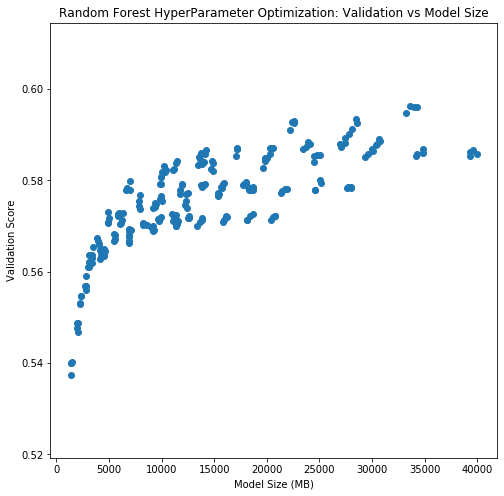

In [300]:
fig1, axes = plt.subplots()
axes.set_title("Random Forest HyperParameter Optimization: Validation vs Model Size")
axes.set_xlabel("Model Size (MB)")
axes.set_ylabel("Validation Score")
model_sizes_mb = df.model_size_MB
axes.scatter(model_sizes_mb, test_acc)
fig1.set_size_inches(8, 8)
figname = os.path.join(output_dir, "rf_hyper_pareto_val_size.pdf")
fig1.savefig(figname)

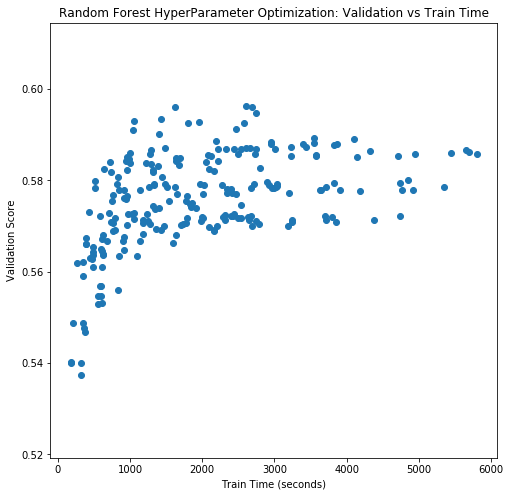

In [297]:
fig1, axes = plt.subplots()
axes.set_title("Random Forest HyperParameter Optimization: Validation vs Train Time")
axes.set_xlabel("Train Time (seconds)")
axes.set_ylabel("Validation Score")
train_time = df.train_time
axes.scatter(train_time, test_acc)
fig1.set_size_inches(8, 8)
figname = os.path.join(output_dir, "rf_hyper_pareto_val_time.pdf")
fig1.savefig(figname)

In [198]:
df_top_6 = df[df.test_accuracy >= 0.59]

In [199]:
top_6_model_small_idx = df_top_6.model_size.idxmin()

In [200]:
df_top_6.loc[top_6_model_small_idx]

names                  RF n_estimators_20_criterion_gini_max_depth_19...
train_accuracy                                                  0.632771
test_accuracy                                                   0.590967
top_2_train                                                     0.750619
top_2_test                                                       0.71166
top_5_train                                                     0.874716
top_5_test                                                      0.848845
train_time                                                       1036.44
score_time                                                       1078.04
model_size                                                   23279555141
model_size_MB                                                    22201.1
train_accuracy_norm                                             0.991004
test_accuracy_norm                                              0.991047
train_time_norm                                    

In [201]:
top_6_model_small_idx

171

In [196]:
grid_params[68]

{'n_estimators': '10',
 'criterion': 'gini',
 'max_depth': '190',
 'min_samples_split': '2',
 'min_samples_leaf': '2',
 'max_leaf_nodes': None,
 'max_features': 'log2'}

In [202]:
grid_params[171]

{'n_estimators': '10',
 'criterion': 'gini',
 'max_depth': '190',
 'min_samples_split': '2',
 'min_samples_leaf': '2',
 'max_leaf_nodes': None,
 'max_features': 'log2'}

##### df.loc[top_6_model_small_idx].names

In [216]:
df.loc[df.test_accuracy.idxmax()]

names                  RF n_estimators_30_criterion_gini_max_depth_20...
train_accuracy                                                  0.636273
test_accuracy                                                   0.596306
top_2_train                                                     0.754076
top_2_test                                                      0.716039
top_5_train                                                     0.877123
top_5_test                                                      0.851289
train_time                                                       2602.25
score_time                                                       2192.46
model_size                                                   35265650727
model_size_MB                                                    33631.9
train_accuracy_norm                                             0.996489
test_accuracy_norm                                                     1
train_time_norm                                    

In [215]:
df.loc[df.model_size.idxmax()].names

'RF n_estimators_80_criterion_gini_max_depth_None_min_samples_split_4_min_samples_leaf_4_max_leaf_nodes_None_max_features_sqrt'

In [221]:
df.test_accuracy_norm.max()

1.0

In [229]:
df["optimal_3"] = 3*df.test_accuracy_norm - 0.05*df.train_time_norm -0.05*df.model_size_norm

In [230]:
df.loc[df.optimal_3.idxmin()]

names                  RF n_estimators_10_criterion_gini_max_depth_20...
train_accuracy                                                  0.545102
test_accuracy                                                   0.537388
top_2_train                                                     0.673148
top_2_test                                                      0.664326
top_5_train                                                      0.82583
top_5_test                                                      0.816575
train_time                                                         318.2
score_time                                                       943.885
model_size                                                    1454992935
model_size_MB                                                    1387.59
train_accuracy_norm                                             0.853702
test_accuracy_norm                                              0.901195
train_time_norm                                    

In [231]:
df.loc[df.optimal_3.idxmax()]

names                  RF n_estimators_20_criterion_gini_max_depth_38...
train_accuracy                                                  0.634297
test_accuracy                                                    0.59286
top_2_train                                                     0.752503
top_2_test                                                      0.713505
top_5_train                                                     0.876584
top_5_test                                                      0.849746
train_time                                                       1059.15
score_time                                                        1061.3
model_size                                                   23663904620
model_size_MB                                                    22567.7
train_accuracy_norm                                             0.993395
test_accuracy_norm                                              0.994222
train_time_norm                                    

In [233]:
df.loc[171]

names                  RF n_estimators_20_criterion_gini_max_depth_19...
train_accuracy                                                  0.632771
test_accuracy                                                   0.590967
top_2_train                                                     0.750619
top_2_test                                                       0.71166
top_5_train                                                     0.874716
top_5_test                                                      0.848845
train_time                                                       1036.44
score_time                                                       1078.04
model_size                                                   23279555141
model_size_MB                                                    22201.1
train_accuracy_norm                                             0.991004
test_accuracy_norm                                              0.991047
train_time_norm                                    

In [235]:
df.loc[df.test_accuracy.idxmax()]

names                  RF n_estimators_30_criterion_gini_max_depth_20...
train_accuracy                                                  0.636273
test_accuracy                                                   0.596306
top_2_train                                                     0.754076
top_2_test                                                      0.716039
top_5_train                                                     0.877123
top_5_test                                                      0.851289
train_time                                                       2602.25
score_time                                                       2192.46
model_size                                                   35265650727
model_size_MB                                                    33631.9
train_accuracy_norm                                             0.996489
test_accuracy_norm                                                     1
train_time_norm                                    

In [240]:
max_test_score = df.test_accuracy.max()
test_constraint = max_test_score * (1-0.01)

In [243]:
df_zone = df.loc[df.test_accuracy >= test_constraint]

In [248]:
df_zone.loc[df_zone.optimal_3.idxmax()]

names                  RF n_estimators_20_criterion_gini_max_depth_38...
train_accuracy                                                  0.634297
test_accuracy                                                    0.59286
top_2_train                                                     0.752503
top_2_test                                                      0.713505
top_5_train                                                     0.876584
top_5_test                                                      0.849746
train_time                                                       1059.15
score_time                                                        1061.3
model_size                                                   23663904620
model_size_MB                                                    22567.7
train_accuracy_norm                                             0.993395
test_accuracy_norm                                              0.994222
train_time_norm                                    

In [273]:
df_zone["optimal_4"] = -2*df_zone.test_accuracy_norm + 0.1*df_zone.train_time_norm + 0.1*df_zone.model_size_norm

/Users/teliov/Library/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [277]:
df_zone.loc[df_zone.optimal_4.idxmin()]

names                  RF n_estimators_20_criterion_gini_max_depth_38...
train_accuracy                                                  0.634297
test_accuracy                                                    0.59286
top_2_train                                                     0.752503
top_2_test                                                      0.713505
top_5_train                                                     0.876584
top_5_test                                                      0.849746
train_time                                                       1059.15
score_time                                                        1061.3
model_size                                                   23663904620
model_size_MB                                                    22567.7
train_accuracy_norm                                             0.993395
test_accuracy_norm                                              0.994222
train_time_norm                                    

In [278]:
df_zone.loc[df_zone.optimal_4.idxmin()].names

'RF n_estimators_20_criterion_gini_max_depth_380_min_samples_split_2_min_samples_leaf_2_max_leaf_nodes_None_max_features_log2'

In [282]:
(max_test_score - df_zone.loc[df_zone.optimal_4.idxmin()].test_accuracy) * 100/max_test_score

0.5777613483475005

In [283]:
max_test_score_model_size = df_zone.loc[df_zone.test_accuracy.idxmax()].model_size

In [284]:
(max_test_score_model_size - df_zone.loc[df_zone.optimal_4.idxmin()].model_size) * 100/max_test_score_model_size

32.89814839037551

In [301]:
max_test_score_train_time = df_zone.loc[df_zone.test_accuracy.idxmax()].train_time

In [302]:
(max_test_score_train_time - df_zone.loc[df_zone.optimal_4.idxmin()].train_time) * 100/max_test_score_train_time

59.29880094163747